<a href="https://colab.research.google.com/github/dilshanindi/Bank_Marketing/blob/main/ML_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import files

uploaded = files.upload()

data = pd.read_csv('bank-additional-full.csv', sep=';')
data.head()


Saving bank-additional-full.csv to bank-additional-full.csv


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Replace 'unknown' values with NaN in categorical *columns*

In [4]:
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
data[categorical_cols] = data[categorical_cols].replace('unknown', np.nan)



#  Handle missing values

           Missing Values  Percentage
job                   330    0.801204
marital                80    0.194231
education            1731    4.202680
default              8597   20.872584
housing               990    2.403613
loan                  990    2.403613


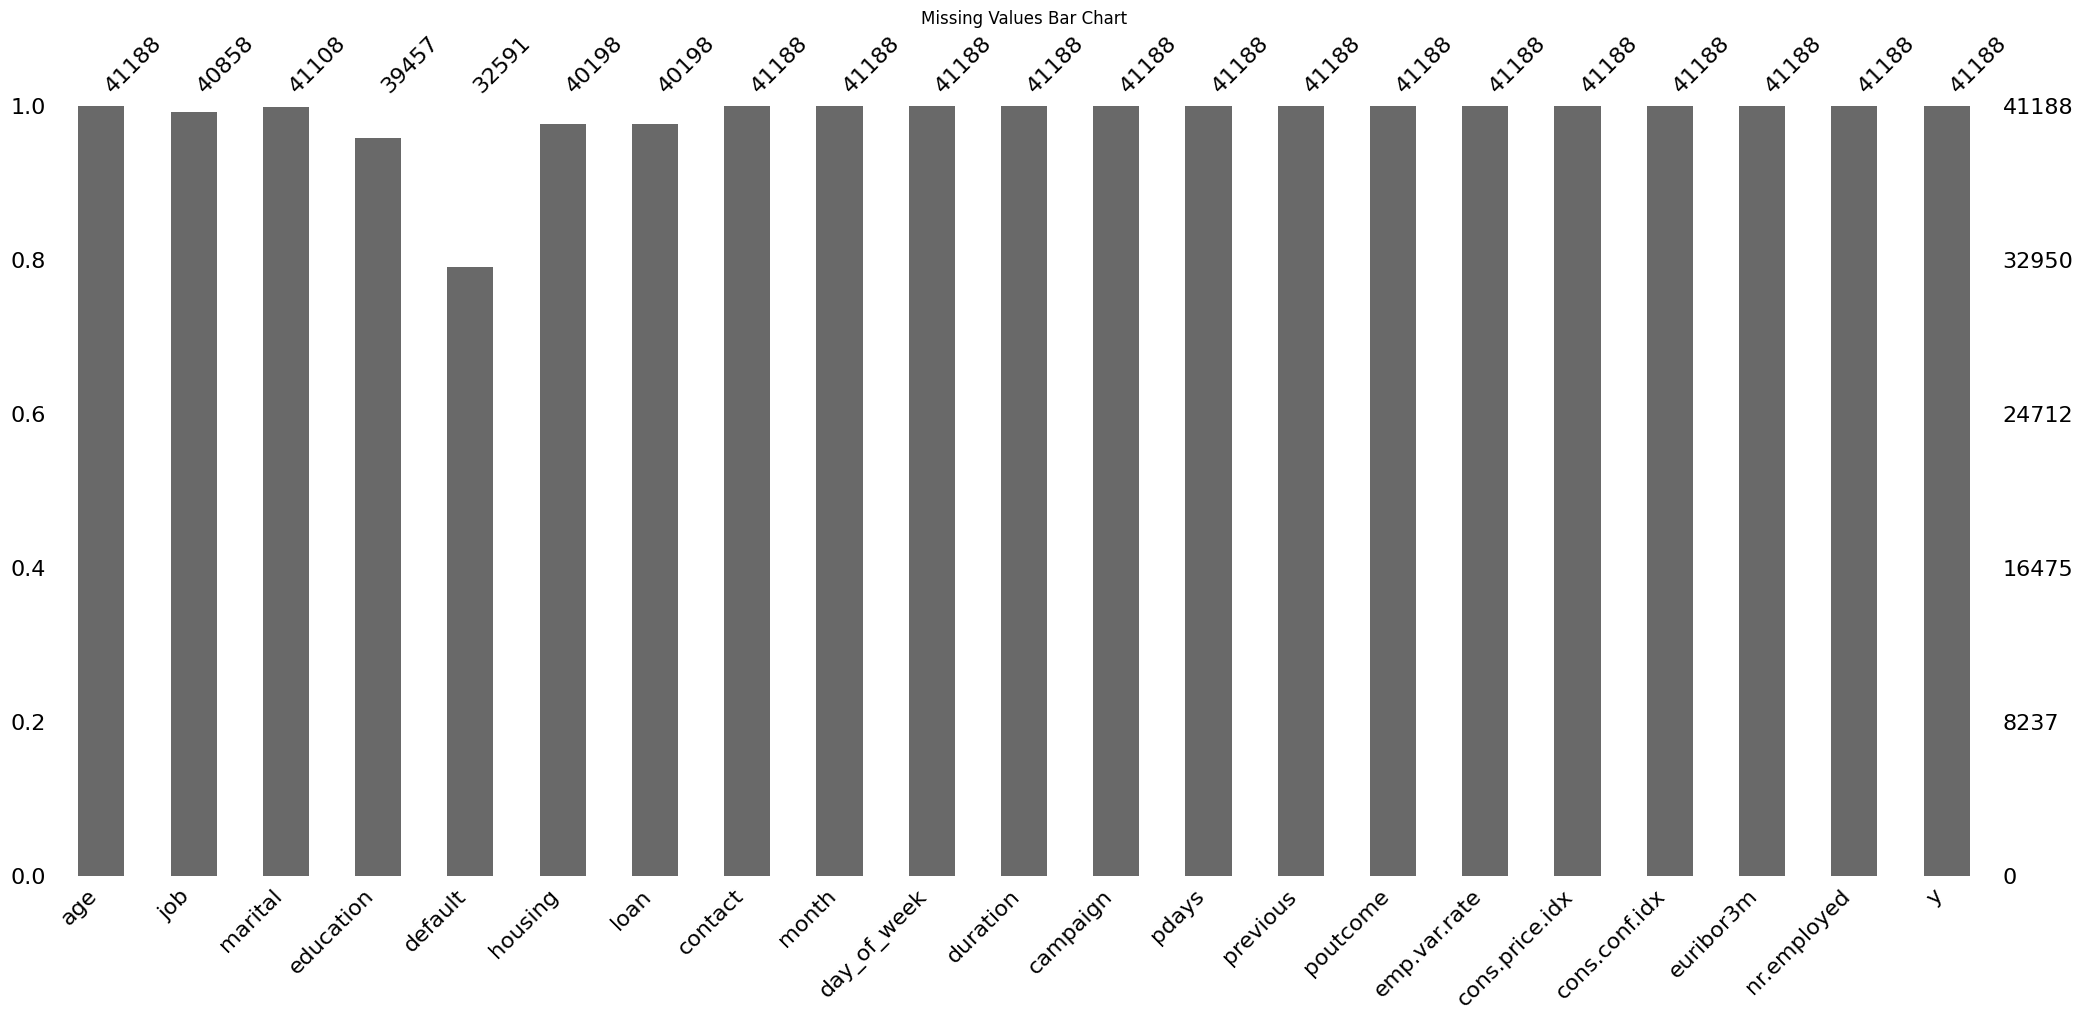

In [5]:
from sklearn.impute import SimpleImputer

# Identify categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns
numerical_cols = data.select_dtypes(include=[np.number]).columns

# Checking for missing values
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

# Display missing value information
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
missing_data = missing_data[missing_data['Missing Values'] > 0]
print(missing_data)

# Visualize missing values
import missingno as msno

# Bar chart for missing values
msno.bar(data)
plt.title("Missing Values Bar Chart")
plt.show()






#  Feature engineering

<ipython-input-6-6db7bba7b8f1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='age_group', data=data, palette='viridis')


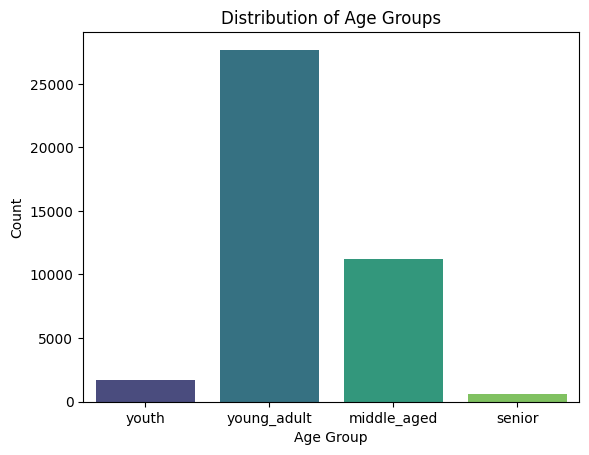

In [6]:

# Binning 'age' into meaningful age groups
data['age_group'] = pd.cut(
    data['age'],
    bins=[0, 25, 45, 65, 100],
    labels=['youth', 'young_adult', 'middle_aged', 'senior'],
    include_lowest=True
)

# Visualizing the distribution of 'age_group'
sns.countplot(x='age_group', data=data, palette='viridis')
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()




<ipython-input-7-5ddd9ed91470>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='job', data=data, order=data['job'].value_counts().index, palette='coolwarm')


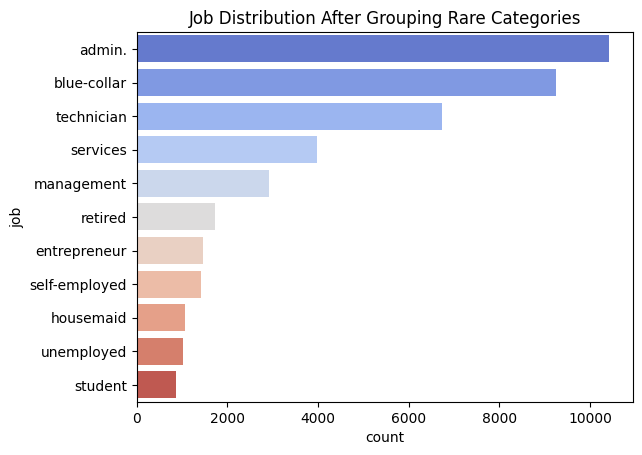

In [7]:
# Grouping rare job categories into 'other'
rare_jobs = data['job'].value_counts()[data['job'].value_counts() < 100].index
data['job'] = data['job'].replace(rare_jobs, 'other')

# Visualizing job distribution
sns.countplot(y='job', data=data, order=data['job'].value_counts().index, palette='coolwarm')
plt.title('Job Distribution After Grouping Rare Categories')
plt.show()


In [8]:
# Interaction between education level and marital status
data['education_marital'] = data['education'] + '_' + data['marital']

# Interaction between contact and day of the week
data['contact_day'] = data['contact'] + '_' + data['day_of_week']

# Display sample interactions
print(data[['education_marital', 'contact_day']].head())


     education_marital    contact_day
0     basic.4y_married  telephone_mon
1  high.school_married  telephone_mon
2  high.school_married  telephone_mon
3     basic.6y_married  telephone_mon
4  high.school_married  telephone_mon


<ipython-input-9-05604c517781>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='month_num', data=data, palette='Set2')


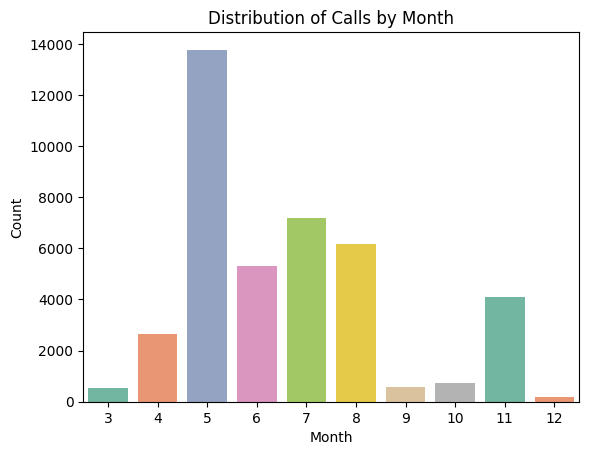

In [9]:
# Encode month as numerical values (Jan=1, Feb=2, ...)
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
data['month_num'] = data['month'].map(month_map)

# Visualize month distribution
sns.countplot(x='month_num', data=data, palette='Set2')
plt.title('Distribution of Calls by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()


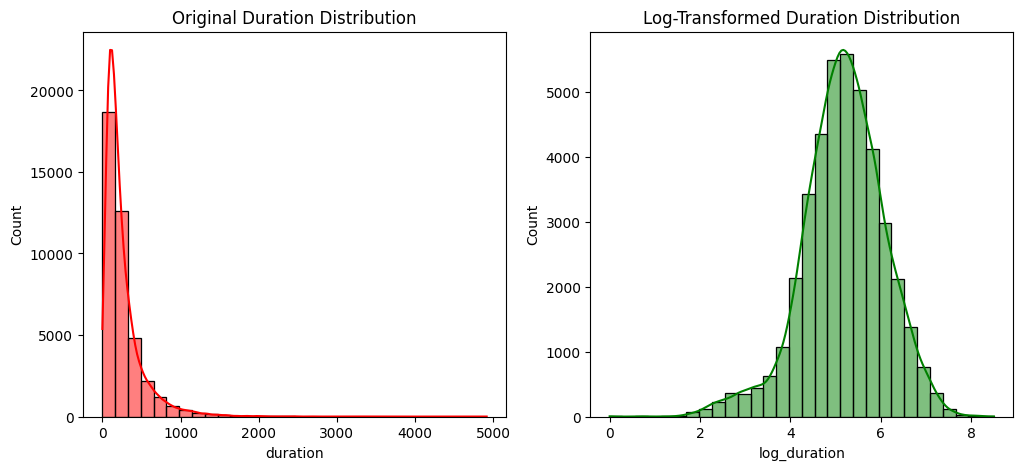

In [10]:
# Log-transform duration to reduce skewness
data['log_duration'] = np.log1p(data['duration'])

# Visualizing original and log-transformed 'duration'
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data['duration'], bins=30, kde=True, ax=ax[0], color='red')
ax[0].set_title('Original Duration Distribution')
sns.histplot(data['log_duration'], bins=30, kde=True, ax=ax[1], color='green')
ax[1].set_title('Log-Transformed Duration Distribution')
plt.show()


In [11]:
# Encode binary categorical variables
binary_cols = ['default', 'housing', 'loan', 'y']  # Ensure 'y' (target) is also numeric
data[binary_cols] = data[binary_cols].replace({'yes': 1, 'no': 0})

# Verify encoding
print(data[binary_cols].head())




   default  housing  loan  y
0      0.0      0.0   0.0  0
1      NaN      0.0   0.0  0
2      0.0      1.0   0.0  0
3      0.0      0.0   0.0  0
4      0.0      0.0   1.0  0


<ipython-input-11-a5481f2c0e07>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[binary_cols] = data[binary_cols].replace({'yes': 1, 'no': 0})


In [12]:
# Step 4: One-hot encode categorical features
# Specify the categorical columns to encode
categorical_features = ['job', 'marital', 'education', 'month', 'day_of_week', 'poutcome', 'age_group', 'education_marital', 'contact_day']

# Apply one-hot encoding
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Ensure no missing values in the features
# This is the modified part. Since X_train is not defined yet,
# we will check for missing values in the entire dataset 'data'
print("Missing values in the data:", data.isnull().sum().sum())

# For checking non-numeric columns, we can also use 'data'
print("Non-numeric columns in data:", data.select_dtypes(include=['object']).columns)

# The rest of your code will come here:
# Step 5, Step 6, Step 7, Step 8, Step 9...

Missing values in the data: 10577
Non-numeric columns in data: Index(['contact'], dtype='object')


In [13]:

# Step 5: Drop unnecessary columns
# Drop features that are irrelevant or highly correlated
data.drop(['duration', 'default', 'contact'], axis=1, inplace=True)




In [14]:
# Step 6: Scale numerical features
numerical_cols = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                  'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])



In [15]:
# Step 7: Separate features and target
X = data.drop(columns=['y'])
y = data['y']



#  Balance the dataset using SMOTE

In [16]:
# Perform train-test split before applying SMOTE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Split data first

# Now you can apply operations on X_train
X_train = X_train.replace('nonexistent', np.nan).dropna() # Drop or replace invalid values
y_train = y_train[X_train.index] # Align y_train with dropped rows in X_train

# Apply SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Display class distribution after SMOTE
from collections import Counter
print("Class distribution after SMOTE (Training):", Counter(y_train_resampled))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE (Training): Counter({0: 28532, 1: 28532})


<ipython-input-17-d310e0c146e3>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_values, palette="viridis")


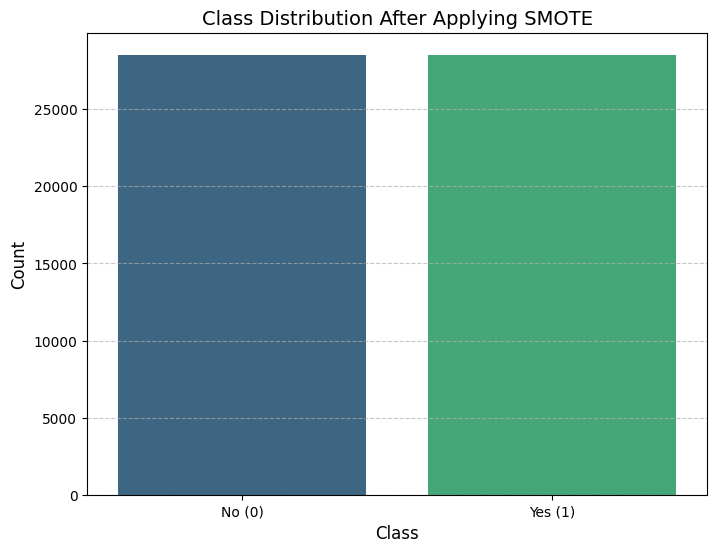

In [17]:
# Count the class distribution
class_counts = Counter(y_train_resampled)

# Prepare data for visualization
class_labels = list(class_counts.keys())
class_values = list(class_counts.values())

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_labels, y=class_values, palette="viridis")
plt.title("Class Distribution After Applying SMOTE", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No (0)', 'Yes (1)'], fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [18]:
# Step 9: Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
# The above line was causing the error because X_resampled and y_resampled were not defined in this scope.
# They were defined in the previous cell where SMOTE was applied.

# Instead, use the resampled data from the previous step directly:
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)

# Check the results
print("Target distribution after SMOTE:", np.bincount(y_train_resampled)) # Use y_train_resampled here
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Target distribution after SMOTE: [28532 28532]
Training Set Shape: (45651, 78)
Testing Set Shape: (11413, 78)


#Random Forest

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

# Create data for tabular display
results_table = [
    ["Accuracy", f"{accuracy:.4f}"],
    ["Precision", f"{precision:.4f}"],
    ["Recall", f"{recall:.4f}"],
    ["F1-Score", f"{f1:.4f}"],
    ["AUC-ROC", f"{roc_auc_rf:.4f}"]
]

# Print the table
print("Random Forest Results Table:")
print(tabulate(results_table, headers=["Metric", "Random Forest"], tablefmt="grid"))


Random Forest Results Table:
+-----------+-----------------+
| Metric    |   Random Forest |
+===========+=================+
| Accuracy  |          0.9599 |
+-----------+-----------------+
| Precision |          0.9395 |
+-----------+-----------------+
| Recall    |          0.983  |
+-----------+-----------------+
| F1-Score  |          0.9608 |
+-----------+-----------------+
| AUC-ROC   |          0.9946 |
+-----------+-----------------+


#Neural Network

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# Define the Neural Network model
nn_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
nn_history = nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype(int)
y_proba_nn = nn_model.predict(X_test)

# Calculate classification metrics
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
roc_auc_nn = roc_auc_score(y_test, y_proba_nn)

# Create data for tabular display
results_table_nn = [
    ["Accuracy", f"{accuracy_nn:.4f}"],
    ["Precision", f"{precision_nn:.4f}"],
    ["Recall", f"{recall_nn:.4f}"],
    ["F1-Score", f"{f1_nn:.4f}"],
    ["AUC-ROC", f"{roc_auc_nn:.4f}"]
]

# Print the table
print("Neural Network Results Table:")
print(tabulate(results_table_nn, headers=["Metric", "Neural Network"], tablefmt="grid"))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network Results Table:
+-----------+------------------+
| Metric    |   Neural Network |
+===========+==================+
| Accuracy  |           0.923  |
+-----------+------------------+
| Precision |           0.9056 |
+-----------+------------------+
| Recall    |           0.9444 |
+-----------+------------------+
| F1-Score  |           0.9246 |
+-----------+------------------+
| AUC-ROC   |           0.9781 |
+-----------+------------------+


# Plot ROC curves

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


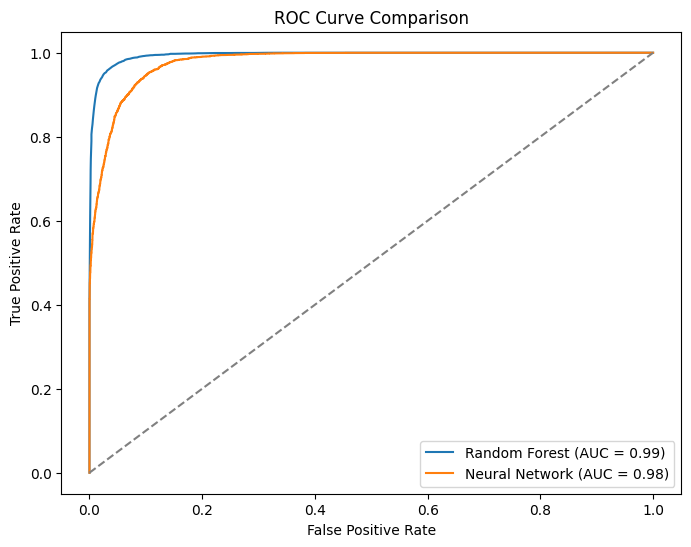

In [21]:

rf_probs = rf_model.predict_proba(X_test)[:, 1]
nn_probs = nn_model.predict(X_test).flatten()

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probs)

plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot(nn_fpr, nn_tpr, label=f"Neural Network (AUC = {roc_auc_nn:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [22]:
# Save results to a CSV
results = pd.DataFrame({
    "Model": ["Random Forest", "Neural Network"],
    "AUC-ROC": [roc_auc_rf, roc_auc_nn]
})
results.to_csv('model_results.csv', index=False)

# Download the results
from google.colab import files
files.download('model_results.csv')
